# Figure 4: S100A4 ensemble epistasis analysis

## Imports

In [9]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Some pretty plot defaults
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

## Load data from ROSETTA. 

Each line of the text file (output-cycles.txt) has 20 entries in the following order, delimited by commas, with no line breaks.  
(Spacing and line breaks here for human sanity).
```
mut_one,mut_two,

apo_mean_ddG_m1,apo_mean_ddG_m2,apo_mean_ddG_m1m2,
ca_mean_ddG_m1,ca_mean_ddG_m2,ca_mean_ddG_m1m2,
capep_mean_ddG_m1,capep_mean_ddG_m2,capep_mean_ddG_m1m2,

apo_std_ddG_m1,apo_std_ddG_m2,apo_std_ddG_m1m2,
ca_std_ddG_m1,ca_std_ddG_m2,ca_std_ddG_m1m2,
capep_std_ddG_m1,capep_std_ddG_m2,capep_std_ddG_m1m2
```

+ `mut_one` and `mut_two` are human-readable names of the mutations (like V72K, etc.)
+ `apo`, `ca`, and `capep` refer to the state on which the calculation was done. 
+ `mean` and `std` indicate whether this is the mean ddG calcualted or the standard deviation on the set of ddG calcultions. 
+ `m1`, `m2`, and `m1m2` refer to whether this is the effect of mutation 1, mutation 2, or mutation 1 and 2 together.  For most mutations, the `m1m2` value is `np.na` because the calculation was not done. 
+ energies are in ROSETTA energy units

In [12]:
def count_lines_in_file(filename):
    """
    Very quickly count the number of lines in a file.
    
    Following this discusssion:
    
    # https://stackoverflow.com/questions/9629179/python-counting-lines-in-a-huge-10gb-file-as-fast-as-possible
    """
    
    def blocks(files, size=65536):
        while True:
            b = files.read(size)
            if not b: break
            yield b

    
    with open(filename, "r",encoding="utf-8",errors='ignore') as f:
        count = sum(bl.count("\n") for bl in blocks(f))
        
    return count


#file_with_cycles = "output-cycles.txt"
#file_with_cycles = 'C:\\Users\\wonde\\EpistasisTheoryAnalysis\\s100a4\\analyze-epistasis\\output-cycles.txt'

num_lines = count_lines_in_file(file_with_cycles)

apo_ddG_mean = np.zeros((num_lines,3),dtype=np.float)
ca_ddG_mean = np.zeros((num_lines,3),dtype=np.float)
capep_ddG_mean = np.zeros((num_lines,3),dtype=np.float)

apo_ddG_std = np.zeros((num_lines,3),dtype=np.float)
ca_ddG_std = np.zeros((num_lines,3),dtype=np.float)
capep_ddG_std = np.zeros((num_lines,3),dtype=np.float)

muts = [[None,None] for _ in range(num_lines)]

with open(file_with_cycles) as f:
    for i, line in enumerate(f.readlines()):
        
        col = line.split(",")
        muts[i][0] = col[0]
        muts[i][1] = col[1]

        data = np.array(col[2:],dtype=np.float)
        
        apo_ddG_mean[i,:] = data[0:3]
        ca_ddG_mean[i,:] = data[3:6]
        capep_ddG_mean[i,:] = data[6:9]

        apo_ddG_std[i,:] = data[9:12]
        ca_ddG_std[i,:] = data[12:15]
        capep_ddG_std[i,:] = data[15:18]        
        
muts = np.array(muts,dtype=np.str)

## Define constants

In [14]:
BETA =  1/(0.001987*298) # energy units in kcal/mol
MU_PEP =  20 # pep chemical potential is 20 kcal/mol (brings capep stability equal to apo)
DG_APO =  0 # apo form is favored 
DG_CA  =    10 # ca form is destabilized by 10 kcal/mol (@ calcium Kd)
DG_CAPEP =  20 # capep form destabilized by 20 kcal/mol (@ calcium Kd and peptide Kd)
MU_CA_RANGE = np.arange(-10,10.1,.1) # Calcium chemical potential range for calculations

## Define observables 

Free energy of each state is: 
$$\Delta G^{\circ}_{x} + \Delta \Delta G_{x,mut} + \sum \mu_{x}$$

Weight is:

$$w_{x} = e^{-\Delta G_{x} /RT}$$

Observable is:

$$\theta = \frac{w_{Ca+pep}}{w_{apo} + w_{Ca} + w_{Ca+pep}}$$

Assume that $\Delta G_{apo}$ is $10 kT$ more stable than Ca state and $20 kT$ more stable than ca/peptide state. 

## Functions for calculating fractional populations, peptide binding observable, and Ca-dep epistasis

In [15]:
def pops(ddG_apo=0,ddG_ca=0,ddG_capep=0,   
         mu_ca=3.5,mu_pep=20,                      
         dG_apo=0,dG_ca=10,dG_capep=20,           
         beta=BETA):
    """
    Calculate the relative fraction of apo, ca, capep
    
    apo_ddG: effect of mutations on apo stability
    ca_ddG: effect of mutations on ca stability
    capep_ddG: effect of mutations on capep stability
    apo_dG: free energy of apo state
    ca_dG: free energy of ca state (no ca)
    capep_dG: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca: chemical potential of calcium
    beta: 1/RT    
    
    Returns the fractional populations of apo, ca, and capep
    """
    
    w_apo =    np.exp(-beta*(dG_apo + ddG_apo))
    w_ca =     np.exp(-beta*(dG_ca  + ddG_ca - 4*mu_ca))
    w_capep =  np.exp(-beta*(dG_capep + ddG_capep - 4*mu_ca - mu_pep))
    
    Z = w_apo + w_ca + w_capep

    return w_apo/Z, w_ca/Z, w_capep/Z

def dg_obs(ddG_apo=0,ddG_ca=0,ddG_capep=0,       # effects of mutations
           mu_ca=3.5,mu_pep=20,                  # chemical potential of calcium and peptide
           dG_apo=0,dG_ca=10,dG_capep=20,        # wildtype thermodynamic parameters
           beta=BETA):                           # 1/RT
    """
    Calculate the free energy of the capep state.
    
    apo_ddG: effect of mutations on apo stability
    ca_ddG: effect of mutations on ca stability
    capep_ddG: effec of mutations on capep stability
    apo_dG: free energy of apo state
    ca_dG: free energy of ca state (no ca)
    capep_dG: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca: chemical potential of calcium
    beta: 1/RT    
    
    Returns dG(apo + ca -> capep)
    """
    
    w_apo, w_ca, w_capep = pops(ddG_apo,ddG_ca,ddG_capep,
                                mu_ca,mu_pep,
                                dG_apo,dG_ca,dG_capep,
                                beta)
    
    return -(1/beta)*np.log(w_capep/(w_apo + w_ca))

def epistasis_vs_ca(apo_ddG,ca_ddG,capep_ddG,
                    dG_apo=0,dG_ca=10,dG_capep=20,
                    mu_pep=20,mu_ca_range=np.arange(-10,10,0.1),
                    additive_in_states=True,beta=BETA):
    """
    Calculate epistasis for the system as a function of calcium concentration.
    
    apo_ddG: effect of mutation 1, mutation 2, and mutation 12 on apo stability
    ca_ddG: effect of mutation 1, mutation 2, and mutation 12 on ca stability
    capep_ddG: effect of mutation 1, mutation 2, and mutation 12 on capep stability
    apo_dG: free energy of apo state
    ca_dG: free energy of ca state (no ca)
    capep_dG: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca_range: chemical potential range of calcium
    additive_in_states: assume that ddG terms sum within each state. If False,
                        the ddG effect of the double mutant would need to 
                        have been calculated in rosetta.
    beta: 1/RT
    """
    
        
    # If we are assuming mutations are additive within a state, 
    # throw out the (possibly) calculated ddG12 value. 
    if additive_in_states:
        apo_ddG[2] = apo_ddG[0] + apo_ddG[1]
        ca_ddG[2] = ca_ddG[0] + ca_ddG[1]
        capep_ddG[2] = capep_ddG[0] + capep_ddG[1]
    
    # free energy of capep for each genotype
    wt =  dg_obs(ddG_apo=0,
                 ddG_ca=0,
                 ddG_capep=0,                          
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    m1 =  dg_obs(ddG_apo=apo_ddG[0],
                 ddG_ca=ca_ddG[0],
                 ddG_capep=capep_ddG[0],  
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    m2 =  dg_obs(ddG_apo=apo_ddG[1],
                 ddG_ca=ca_ddG[1],
                 ddG_capep=capep_ddG[1], 
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    m12 = dg_obs(ddG_apo=apo_ddG[2],
                 ddG_ca=ca_ddG[2],
                 ddG_capep=capep_ddG[2],  
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)  

    
    # magnitude of epistasis (signed)
    mag = (m12 - m2) - (m1 - wt)
    
    # Sign of mutation 1 (will be False if mutation effect has same
    # sign in both backgrounds; True if opposite signs)
    sign1 = (m12 - m2)/(m1 - wt)
    sign1 = sign1 < 0

    # Sign of mutation 2 (will be False if mutation effect has same
    # sign in both backgrounds; True if opposite signs)
    sign2 = (m12 - m1)/(m2 - wt)
    sign2 = sign2/np.abs(sign2) < 0

    return mag, sign1, sign2

# Panel 4B: Manipulation of ensemble energy levels with calcium and peptide

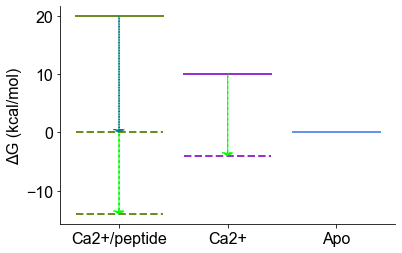

In [35]:
def plot_ensemble_levels(dG_apo=0,dG_ca=10,dG_capep=20,mu_ca=3.5,mu_pep=20):
    
    plt.figure()
    
    # x-placement for edges of conformation
    x0 = 0
    x1 = 1
    x2 = 2
    
    #plot capep
    plt.plot([x0,x0+0.8],[dG_capep,dG_capep],lw=2,color="olivedrab",zorder=10)
    
    #peptide addition to capep
    plt.plot([x0,x0+0.8],[dG_capep-mu_pep,dG_capep-mu_pep],'--',lw=2,color="olivedrab",zorder=10)
    plt.arrow((x0+0.4),dG_capep,0,-mu_pep,color='teal',linestyle='--',length_includes_head=True,head_width=0.1,head_length=0.50,zorder=20)
    
    #calcium addition to capep
    plt.plot([x0,x0+0.8],[dG_capep-mu_pep-4*mu_ca,dG_capep-mu_pep-4*mu_ca],'--',lw=2,color="olivedrab",zorder=10)
    plt.arrow((x0+0.4),dG_capep-mu_pep,0,-4*mu_ca,color='lime',linestyle='--',length_includes_head=True,head_width=0.1,head_length=0.50,zorder=20)
    
    #plot ca
    plt.plot([x1,x1+0.8],[dG_ca,dG_ca],lw=2,color="darkorchid",zorder=10)
    
    #calcium addition to ca
    plt.plot([x1,x1+0.8],[dG_ca-4*mu_ca,dG_ca-4*mu_ca],'--',lw=2,color="darkorchid",zorder=10)
    plt.arrow((x1+0.4),dG_ca,0,-4*mu_ca,color='lime',linestyle='--',length_includes_head=True,head_width=0.1,head_length=0.50,zorder=20)
    
    #plot apo
    plt.plot([x2,x2+0.8],[dG_apo,dG_apo],lw=2,color="cornflowerblue",zorder=10)
    
    #general plot settings
    plt.xticks([0.4,1.4,2.4],['Ca2+/peptide','Ca2+','Apo'])
    plt.ylabel('ΔG (kcal/mol)')
    #plt.savefig('final-figures/Fig4B-ensemble-energy-levels.svg')
    
#call the function
plot_ensemble_levels()

# Panel 4C: Plot fractional population as a function of Ca2+ concentration

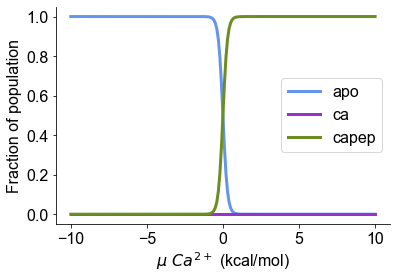

In [17]:
def pop_curves(ddG_a,ddG_c,ddG_cp):
    '''
    Plot fractional population of each state as a
    function of the negative Ca2+ chemical potential.
    ddG_a: effect of mutation of apo stability
    ddG_c: effect of mutation on ca stability
    ddG_cp: effect of mutation on cp stability
    
    '''
    
    fig, ax = plt.subplots(1,1)
    
    #calculate fractional populations
    apo, ca, capep = pops(ddG_apo=ddG_a,
                      ddG_ca=ddG_c,
                      ddG_capep=ddG_cp,
                      mu_ca=MU_CA_RANGE,
                      mu_pep=MU_PEP,
                      beta=BETA,
                      dG_apo=DG_APO,
                      dG_ca=DG_CA,
                      dG_capep=DG_CAPEP)
    
    #plot fractions for each structure
    ax.plot(MU_CA_RANGE,apo,lw=3,color='cornflowerblue',label="apo")
    ax.plot(MU_CA_RANGE,ca,lw=3,color='darkorchid',label="ca")
    ax.plot(MU_CA_RANGE,capep,lw=3,color='olivedrab',label="capep")
    
    #general plot settings
    ax.set_ylabel('Fraction of population')
    ax.set_xlabel("$\mu\ Ca^{2+}$ (kcal/mol)")
    ax.legend()
        
    #fig.savefig('final-figures/Fig4C-frac-wt.svg')
        
#call the function for WT ensemble (ddG_a, ddG_c, and ddG_cp are zero)
pop_curves(0,0,0)

### Look at effect of peptide on the ensemble (not shown in Figure 4)

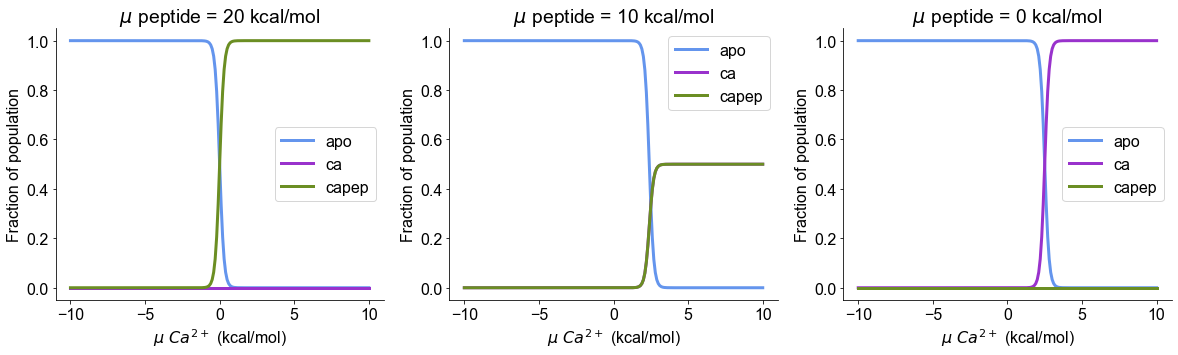

In [18]:
def pep_curves(ddG_a,ddG_c,ddG_cp):
    '''
    Plot fractional population of each state as a
    function of the negative Ca2+ chemical potential.
    ddG_a: effect of mutation of apo stability
    ddG_c: effect of mutation on ca stability
    ddG_cp: effect of mutation on cp stability
    
    '''
    
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    
    peps = [20,10,0]
    
    for i in range(3):
    
        #calculate fractional populations
        apo, ca, capep = pops(ddG_apo=ddG_a,
                          ddG_ca=ddG_c,
                          ddG_capep=ddG_cp,
                          mu_ca=MU_CA_RANGE,
                          mu_pep=peps[i],
                          beta=BETA,
                          dG_apo=DG_APO,
                          dG_ca=DG_CA,
                          dG_capep=DG_CAPEP)

        #plot fractions for each structure
        ax[i].plot(MU_CA_RANGE,apo,lw=3,color='cornflowerblue',label="apo")
        ax[i].plot(MU_CA_RANGE,ca,lw=3,color='darkorchid',label="ca")
        ax[i].plot(MU_CA_RANGE,capep,lw=3,color='olivedrab',label="capep")

        #general plot settings
        ax[i].set_ylabel('Fraction of population')
        ax[i].set_xlabel("$\mu\ Ca^{2+}$ (kcal/mol)")
        ax[i].set_title("$\mu\ $peptide = {} kcal/mol".format(str(peps[i])))
        ax[i].legend()
        
    #fig.savefig('paper-plots/Fig4C-pepmanip2.pdf')
        
#call the function for WT ensemble (ddG_a, ddG_c, and ddG_cp are zero)
pep_curves(0,0,0)

# Panel 4D: Look for ca-dependent epistasis in selected mutation pairs
### Calculate epistasis at mu ca = 3.5 kcal/mol
* try to only run this code once

In [19]:
all_mag_select = np.zeros(apo_ddG_mean.shape[0],dtype=np.float)
all_sign_select = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)
all_recip_select = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)

for i in range(len(apo_ddG_mean)):
        
    mag, sign1, sign2 = epistasis_vs_ca(apo_ddG_mean[i,:],
                                        ca_ddG_mean[i,:],
                                        capep_ddG_mean[i,:],
                                        dG_apo=DG_APO,
                                        dG_ca=DG_CA,
                                        dG_capep=DG_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=3.5,
                                        additive_in_states=True,
                                        beta=BETA)
    
    
    # If sign on both, reciprocal
    reciprocal = np.logical_and(sign1,sign2)
    
    # Sign (as a class) will be sign on one mut but *not* reciprocal
    sign = np.logical_and(np.logical_or(sign1,sign2),
                          np.logical_not(reciprocal))
    
    # Record magnitude of epistasis
    all_mag_select[i] = mag
    
    # Record whether it is reciprocal or sign at this maximum value
    all_recip_select[i] = reciprocal
    all_sign_select[i] = sign

C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in double_scalars


### Generate dataframe for specific mutations at mu Ca = -15 kcal/mol
- M85K: apo buried charge, ca exposed charge
- F145R: apo exposed charge, ca buried charge
- F78A: apo exposed hole, ca buried hole
- L109I: apo no change, ca no change

In [20]:
df = pd.DataFrame({'m1':muts[:,1],'m2':muts[:,0],
                   'apo_m1':apo_ddG_mean[:,0],'apo_m2':apo_ddG_mean[:,1],
                   'ca_m1':ca_ddG_mean[:,0],'ca_m2':ca_ddG_mean[:,1],
                   'capep_m1':capep_ddG_mean[:,0],'capep_m2':capep_ddG_mean[:,1],
                   'all_mag_sel':all_mag_select,'all_sign_sel':all_sign_select,'all_recip_sel':all_recip_select})

select_muts = ['M85K','F145R','F78A','L109I']

check_m1 = df.m1.isin(select_muts)
check_m2 = df.m2.isin(select_muts)

select_df = df[check_m1 & check_m2]

select_df

,m1,m2,apo_m1,apo_m2,ca_m1,ca_m2,capep_m1,capep_m2,all_mag_sel,all_sign_sel,all_recip_sel
3650640,M85K,L109I,7.809,0.021,2.213,0.059,5.786,0.274,-0.000046,False,False
3651212,M85K,F78A,7.809,4.761,2.213,11.287,5.786,13.262,-2.530258,False,False
3652201,M85K,F145R,7.809,-1.032,2.213,7.495,5.786,4.487,-4.436461,False,True
3982518,L109I,F78A,0.021,4.761,0.059,11.287,0.274,13.262,0.037445,False,False
3983508,L109I,F145R,0.021,-1.032,0.059,7.495,0.274,4.487,0.037937,False,False
4876241,F78A,F145R,4.761,-1.032,11.287,7.495,13.262,4.487,3.992152,False,False


### Organize select mutation dataframe by epistasis class 
- 0 = reciprocal sign epistasis (F145R/M85K)
- 1 = magnitude epistasis (F145R/F78A)
- 2 = no epistasis (F145R/L109I)

In [21]:
#Sign: F145R + M85K (opposite directions equal magnitude)
s_idx = 3652201

#Magnitude: F145R + F78A (diff mag but same direction)
m_idx = 4876241

#None: F145R + L109I
n_idx = 3983508

index_list = [s_idx, m_idx, n_idx]

ex1_df = select_df.loc[index_list]
ex1_df = ex1_df.reset_index()
ex1_df.loc[:,"index"] = 0
ex1_df

ex_df = ex1_df[['index','m2','m1','apo_m2','apo_m1',
                'ca_m2','ca_m1','capep_m2','capep_m1',
                'all_mag_sel','all_sign_sel','all_recip_sel']]

ex_arr = ex_df.values

name_arr = ex_arr[:,[1,2]]
apo_ddg_arr = ex_arr[:,[3,4,0]]
ca_ddg_arr = ex_arr[:,[5,6,0]]
capep_ddg_arr = ex_arr[:,[7,8,0]]
type_arr = np.array(['Sign','Magnitude','None'])

ex_df  

,index,m2,m1,apo_m2,apo_m1,ca_m2,ca_m1,capep_m2,capep_m1,all_mag_sel,all_sign_sel,all_recip_sel
0,0,F145R,M85K,-1.032,7.809,7.495,2.213,4.487,5.786,-4.436461,False,True
1,0,F145R,F78A,-1.032,4.761,7.495,11.287,4.487,13.262,3.992152,False,False
2,0,F145R,L109I,-1.032,0.021,7.495,0.059,4.487,0.274,0.037937,False,False


### Plot epistasis for specific mutation pairs as a fxn of ca concentration

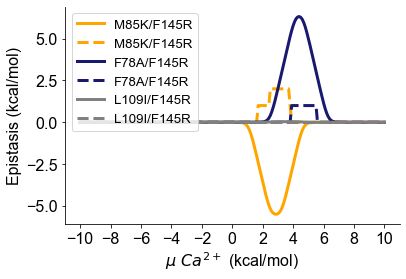

In [22]:
def plot_epcurves(inds=np.arange(3)):
    '''
    Plot epistasis for mutation pairs. 
    inds: indices of mutation pair in ex_df
    (0:sign, 1:magnitude, 2:no epistasis)
    
    Dotted lines show sign epistasis (magnitude=1)
    or reciprocal sign epistasis (magnitude=2)
    '''
    colors = ['orange','midnightblue','grey']
    
    for i in inds:
        m1,m2 = name_arr[i,:]
        mag,sign1,sign2 = epistasis_vs_ca(apo_ddg_arr[i,:],ca_ddg_arr[i,:],capep_ddg_arr[i,:],
                                          dG_apo=DG_APO,dG_ca=DG_CA,dG_capep=DG_CAPEP,
                                          mu_pep=MU_PEP,mu_ca_range=MU_CA_RANGE,
                                          additive_in_states=True,beta=BETA) 

        #Plot epistasis curves
        plt.plot(MU_CA_RANGE,mag,lw=3,color=colors[i],label=str(m2+'/'+m1))
        
        #Plot sign and reciprocal sign truth
        plt.plot(MU_CA_RANGE,sign1.astype(int)+sign2.astype(int),'--',lw=3,color=colors[i],label=str(m2+'/'+m1))

        
        
    plt.xlabel("$\mu\ Ca^{2+}$ (kcal/mol)")
    plt.ylabel('Epistasis (kcal/mol)')
    plt.xticks(np.arange(-10,12,2))
    plt.legend(fontsize='small',loc='upper left')
    
    #plt.savefig('final-figures/Fig4D-neg-ep-vs-ca.svg')

# call the function
plot_epcurves()

# Panel 4E: Look at global patterns of epistatic magnitude across all mutation pairs

### Calculate maximum epistasis for each mutation pair within calcium chemical potential range
* try to only run this code once

In [24]:
#Total number of mutation pairs in dataset
len(apo_ddG_mean)

5686833

In [25]:
all_mag = np.zeros(apo_ddG_mean.shape[0],dtype=np.float)
all_sign = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)
all_recip  = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)

for i in range(len(apo_ddG_mean)):
        
    mag, sign1, sign2 = epistasis_vs_ca(apo_ddG_mean[i,:],
                                        ca_ddG_mean[i,:],
                                        capep_ddG_mean[i,:],
                                        dG_apo=DG_APO,
                                        dG_ca=DG_CA,
                                        dG_capep=DG_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)
    
    
    # If sign on both, reciprocal
    reciprocal = np.logical_and(sign1,sign2)
    
    # Sign (as a class) will be sign on one mut but *not* reciprocal
    sign = np.logical_and(np.logical_or(sign1,sign2),
                          np.logical_not(reciprocal))
    
    # Index of maximum epistasis over this [Ca] range
    max_index = np.argmax(np.abs(mag))
    
    # Record magnitude of epistasis
    all_mag[i] = mag[max_index]
    
    # Record whether it is reciprocal or sign at this maximum value
    all_recip[i] = reciprocal[max_index]
    all_sign[i] = sign[max_index]

C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in true_divide
C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in true_divide
C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide


### Plot histogram of maximum epistatic magnitude (and type) for every mutation pair

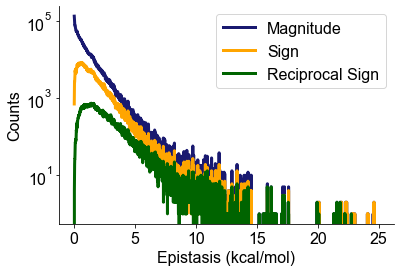

In [26]:
def plot_maxepistasis():
    '''
    Plot histogram of each pair's maximum epistasis
    within Ca chemical potential range.
    
    Uses all_mag, all_sign, and all_recip to retrieve
    the value and type of epistasis at maximum Ca2+ position.
    
    Counts (y-axis) on log scale
    '''
    
    fig,ax = plt.subplots(1,1)
    bins=np.arange(0,25,0.01)

    counts, _ = np.histogram(abs(all_mag[np.logical_not(np.logical_and(all_sign,all_recip))]),bins)
    out_bins = (bins - (bins[1] - bins[0])/2)[1:]

    ax.plot(out_bins,counts,"-",color="midnightblue",label="Magnitude",linewidth=3)

    counts, _ = np.histogram(abs(all_mag[all_sign]),bins)
    ax.plot(out_bins,counts,"-",color="orange",label="Sign",linewidth=3)

    counts, _ = np.histogram(abs(all_mag[all_recip]),bins)
    ax.plot(out_bins,counts,"-",color="darkgreen",label="Reciprocal Sign",linewidth=3)

    ax.set_xlabel("Epistasis (kcal/mol)")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")
    ax.legend(loc="upper right")

    #fig.savefig('final-figures/Fig4E-epistasis-counts.svg')
    
# call the function
plot_maxepistasis()

# Panel 4F: Fractional contributions of epistasis types based on cutoff threshold

,Cutoff (kcal/mol),Fx_none,Fx_mag,Fx_sign,Fx_recip
0,0,0.000000,0.724447,0.244200,0.031352
1,1,0.694456,0.152864,0.128440,0.024240
2,2,0.890732,0.044062,0.051779,0.013427
3,3,0.959076,0.013801,0.020329,0.006794
4,4,0.983752,0.004622,0.008333,0.003293
5,5,0.993105,0.001728,0.003561,0.001607


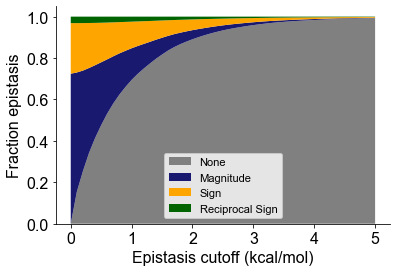

In [27]:
def plot_threshold(all_m,all_s,all_r):
    '''
    Generate continuous stacked bar plot for the 
    fraction of mutation pairs composing each class 
    of epistasis as the epistatic 
    cutoff in kcal/mol is increased. 
    
    Pairs with maximum epistasis below the cutoff are
    considered to have no epistasis.
    
    Returns fx_df: dataframe with epistatic fractions
    for integer cutoff values.
    
    all_m: array with maximum epistatic magnitude 
    all_s: array with truth of sign epistasis
    all_r: array with truth of reciprocal sign epistasis
    '''
    cutoff_range=np.arange(0,5.1,0.1)
    int_cutoff=np.arange(0,6,1)

    sign_arr = np.zeros(len(cutoff_range))
    recip_arr = np.zeros(len(cutoff_range))
    mag_arr = np.zeros(len(cutoff_range))
    none_arr = np.zeros(len(cutoff_range))
    
    s_arr = np.zeros(len(int_cutoff))
    r_arr = np.zeros(len(int_cutoff))
    m_arr = np.zeros(len(int_cutoff))
    n_arr = np.zeros(len(int_cutoff))
    j=0

    #calculate epistasis fractions for each cutoff
    for i,cutoff in enumerate(cutoff_range):

        mask = np.abs(all_m) > cutoff

        fx_sign = np.sum(all_s[mask])/all_s.shape[0]
        sign_arr[i] = fx_sign

        fx_recip = np.sum(all_r[mask])/all_s.shape[0]
        recip_arr[i] = fx_recip

        fx_mag = np.sum(np.logical_not(np.logical_or(all_s[mask],all_r[mask])))/all_s.shape[0]
        mag_arr[i] = fx_mag

        fx_none = 1 - fx_sign - fx_recip - fx_mag
        none_arr[i] = fx_none
   
        if cutoff in int_cutoff:
            s_arr[j] = fx_sign
            r_arr[j] = fx_recip
            m_arr[j] = fx_mag
            n_arr[j] = fx_none
            j += 1
            
    fx_df = pd.DataFrame({'Cutoff (kcal/mol)':int_cutoff,'Fx_none':n_arr,'Fx_mag':m_arr,'Fx_sign':s_arr,'Fx_recip':r_arr})
        
    plt.stackplot(cutoff_range,none_arr,mag_arr,sign_arr,recip_arr,
                  labels=['None','Magnitude','Sign','Reciprocal Sign'],
                  colors=['grey','midnightblue','orange','darkgreen'])
    
    plt.ylabel('Fraction epistasis')
    plt.xlabel('Epistasis cutoff (kcal/mol)')
    plt.legend(loc='lower center',fontsize='x-small')

    #plt.savefig('final-figures/Fig4F-cutoff-curves-kT.svg')
    
    return fx_df

#Call the function
plot_threshold(all_m=all_mag,all_s=all_sign,all_r=all_recip)

# Panels 4H-K: Energy diagrams for selected mutation pairs at mu ca = 3.5 kcal/mol

### Plotting functions

In [31]:
def _plot_states_ca(dG_apo=0,dG_ca=0,                        
                    ddG_apo=None,ddG_ca=None,         
                    observable=0,x_location=0,
                    arrow_colors=None):                              
    """
    Draw conformation energies and effects of mutations for a given genotype.
    
    dG_apo: stability of apo before mutation
    dG_ca: stability of ca before mutation
    ddG_apo: effect of mutations to apo structure.  
           If None, no mutations.
           If float, single mutation (one arrow).
           If list of floats, multiple mutations (each with own arrow)
    ddG_ca: effect of mutations to ca.  (Same syntax as ddG_apo).
    observable: observable <dGapo,ca>
    x_location: where to draw states on total plot.
    arrow_colors: color to draw each arrow.
                  If None, all arrows black.
                  Otherwise, must be a list of colors, in order.  Arrows are
                  plotted in order ddG_apo, then ddG_ca.   
    """

    # x-placement for edges of genotypes
    x0 = 0
    x1 = 2
    x2 = 2.5
    x3 = 4.5

    # If ddG_ca specified, add dashed line for dG_ca
    if ddG_ca is None:
        ddG_ca = 0
    else:        
        plt.plot([x0+x_location,x1+x_location],[dG_ca,dG_ca],"--",lw=2,color="darkorchid",zorder=10)
        
    # If ddG_apo is specified, add dashed line for dG_apo
    if ddG_apo is None:
        ddG_apo = 0
    else:        
        plt.plot([x2+x_location,x3+x_location],[dG_apo,dG_apo],"--",lw=2,color="cornflowerblue",zorder=10)
    

    # If ddG_ca is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    try:
        len(ddG_ca)
        total_ddG_ca = sum(ddG_ca)
    except TypeError:
        total_ddG_ca = ddG_ca
        ddG_ca = [ddG_ca,]
        
    # If ddG_apo is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    try:
        len(ddG_apo)
        total_ddG_apo = sum(ddG_apo)
    except TypeError:
        total_ddG_apo = ddG_apo
        ddG_apo = [ddG_apo,]
    
    # Plot energy levels
    plt.plot([x0+x_location,x1+x_location],[dG_ca+total_ddG_ca,dG_ca+total_ddG_ca],lw=2,color="darkorchid",zorder=10)
    plt.plot([x2+x_location,x3+x_location],[dG_apo+total_ddG_apo,dG_apo+total_ddG_apo],lw=2,color="cornflowerblue",zorder=10)
    
    # Plot observable
    plt.plot([x0+x_location,x3+x_location],[observable,observable],lw=4,color="black",zorder=0)
    
    # Count through arrow colors
    color_counter = 0
        
    current = dG_ca
    for counter, ca_arrow in enumerate(ddG_ca):
        
        # If this ddG is 0, do not draw an arrow
        if ca_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x0 + (x1 - x0)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = ca_arrow/np.abs(ca_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,current,0,ca_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + ca_arrow
        color_counter += 1
        
    current = dG_apo
    for counter, apo_arrow in enumerate(ddG_apo):
        
        # If this ddG is 0, do not draw an arrow
        if apo_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x2 + (x3 - x2)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = apo_arrow/np.abs(apo_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,current,0,apo_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + apo_arrow
        color_counter += 1
        
    plt.ylabel('ΔG (kcal/mol)')

def plot_state_cycle_ca(index,apo_ddG,ca_ddG,capep_ddG,
                        dG_apo,dG_ca,dG_capep,
                        mu_pep,mu_ca,
                        additive_in_states=True,beta=BETA,
                        ylim=(-11,15)):
    """
    Calculate epistasis for the system as a function of calcium concentration.
    
    apo_ddG: effect of mutation 1, mutation 2, and mutation 12 on apo stability
    ca_ddG: effect of mutation 1, mutation 2, and mutation 12 on ca stability
    capep_ddG: effect of mutation 1, mutation 2, and mutation 12 on capep stability
    apo_dG: free energy of apo state
    ca_dG: free energy of ca state (no ca)
    capep_dG: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca_range: chemical potential range of calcium
    additive_in_states: assume that ddG terms sum within each state. If False,
                        the ddG effect of the double mutant would need to 
                        have been calculated in rosetta.
    beta: 1/RT
    """
    
        
    # If we are assuming mutations are additive within a state, 
    # throw out the (possibly) calculated ddG12 value. 
    if additive_in_states:
        apo_ddG[2] = apo_ddG[0] + apo_ddG[1]
        ca_ddG[2] = ca_ddG[0] + ca_ddG[1]
        capep_ddG[2] = capep_ddG[0] + capep_ddG[1]
    
    # free energy of capep for each genotype
    ab =  dg_obs(ddG_apo=0,
                 ddG_ca=0,
                 ddG_capep=0,                          
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    Ab =  dg_obs(ddG_apo=apo_ddG[0],
                 ddG_ca=ca_ddG[0],
                 ddG_capep=capep_ddG[0],  
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    aB =  dg_obs(ddG_apo=apo_ddG[1],
                 ddG_ca=ca_ddG[1],
                 ddG_capep=capep_ddG[1], 
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    AB = dg_obs(ddG_apo=apo_ddG[2],
                 ddG_ca=ca_ddG[2],
                 ddG_capep=capep_ddG[2],  
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)  
    
    
    dG_j = -(1/beta)*np.log(np.exp(-beta*(dG_apo)))
    dG_k = -(1/beta)*np.log(np.exp(-beta*(dG_ca - 4*mu_ca)))
    ddG_Aj, ddG_Bj = apo_ddG[0:2]
    ddG_Ak, ddG_Bk = ca_ddG[0:2]
    
    # Plot states for each genotype, offseting by x_location for each one
    _plot_states_ca(dG_j,dG_k,observable=ab,x_location=0)
    _plot_states_ca(dG_j,dG_k,[ddG_Aj],[ddG_Ak],observable=Ab,x_location=6,arrow_colors=["orange","orange"])
    _plot_states_ca(dG_j,dG_k,[ddG_Bj],[ddG_Bk],observable=aB,x_location=12,arrow_colors=["green","green"])
    _plot_states_ca(dG_j,dG_k,[ddG_Bj,ddG_Aj],[ddG_Bk,ddG_Ak],observable=AB,x_location=18,arrow_colors=["green","orange","green","orange"])
    
    # Print epistasis
    print("Ab-ab:",Ab-ab)
    print("AB-aB:",AB-aB,'\n')
    print("aB-ab:",aB-ab)
    print("AB-Ab",AB-Ab)
    print("Epistasis:",(AB-aB)-(Ab-ab))
    
    plt.ylim(ylim)
    plt.xticks([2,8,14,20],['ab','Ab','aB','AB'])
    #plt.savefig('final-figures/Fig4I-energy-diagram-none.svg')

    return None

def ex_plot(index):
    '''
    Plot energy diagrams for mutations at indicated index in 
    the ex_df dataframe (0:sign, 1:magnitude, 2:no epistasis)
    
    Ca2+ chemical potential is set at -15 kT.

    index: position in ex_df dataframe    
    '''
    
    m1,m2 = name_arr[index,:]
    print('A: {}, B: {}'.format(m1,m2))   
    
    #create energy diagrams at mu ca = 3.5 kcal/mol
    plot_state_cycle_ca(index,apo_ddg_arr[index,:],ca_ddg_arr[index,:],capep_ddg_arr[index,:],
                        dG_apo=DG_APO,dG_ca=DG_CA,dG_capep=DG_CAPEP,
                        mu_pep=MU_PEP,mu_ca=3.5)
    
    return None

### Reciprocal sign epistasis pair: F145R + M85K

A: F145R, B: M85K
Ab-ab: 1.5185939001317745
AB-aB: -2.9178671217281273 

aB-ab: 3.5723108251420257
AB-Ab -0.8641501967178762
Epistasis: -4.436461021859902


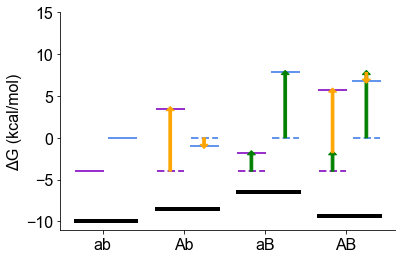

In [32]:
ex_plot(0)

### Magnitude epistasis pair: F145R + F78A

A: F145R, B: F78A
Ab-ab: 1.5185939001317745
AB-aB: 5.510745515328225 

aB-ab: 4.508565260214765
AB-Ab 8.500716875411216
Epistasis: 3.992151615196451


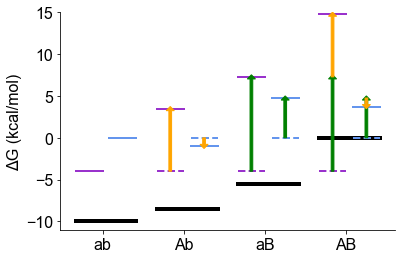

In [33]:
ex_plot(1)

### No epistasis pair: F145R + L109I

A: F145R, B: L109I
Ab-ab: 1.5185939001317745
AB-aB: 1.5565306514134551 

aB-ab: 0.21504565345512638
AB-Ab 0.252982404736807
Epistasis: 0.037936751281680614


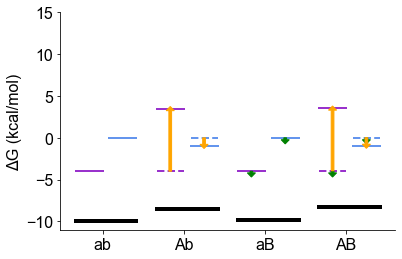

In [34]:
ex_plot(2)